# Who feeds the world ? And how wealthy are they ?

## Abstract <a name="abstract"></a>

Our main goal in this project is to find social and economic world-wide relations of countries based on the state of their agricultural sector, using indicators such as imports, exports, production, self-sufficiency, etc. In order to find such indicators, we would like to use the data from the "Global Food & Agriculture Statistics" datasets. First, we would like to produce a map showing which countries "feed the world" i.e. which countries are net-exporting food. That map would contain a slider to show how this evolved over the past fifty years. Then we would like to show countrywise the level of food self-sufficiency i.e. the way a country does not need to trade with other ones in order to feed its population. We will also compare it to nations' economic development and see if some correlations can be found. We will visualize our best findings with several interactive maps and plots.

## Research questions <a name="abstract2"></a>

We would like to work on the following research questions:

- How does the production and consumption of food look like from a geographical point of view ? Which countries are net food exporters or importers? How did this evolve over the last few decades ?
- What's the level of self-sufficiency in food production of individual countries and how does this change over time ?
- Is there a link between the GDP per capita and the agricultural trade balance ? Are countries that are net exporters or importers richer ? Are self-sufficient countries richer ?
- If we find any relations, are they also still valid if we check for specific crops ? Are there some crops that are mostly produced by richer countries, some that are mostly produced by poorer countries?


# Table of contents <a name="toc"></a>


[Abstract](#abstract)

[Research questions](#abstract2) 

[Table of contents](#toc)

1. [Data cleansing and preprocessing](#1)

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
        
    5. [Preprocessing the data set](#1E)
        
    6. [Making one uniformized dataframe](#1F)
        
2. [Data exploration and first observations](#2)
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Prices of food](#2B)  
                
    3. [Structure of international trade](#2C)      
        
    4. [Economic classification of countries](#2D)    
        
3. [Descriptive data analysis](#3)

    1. [Production and consumption of food from a time-space geography point of view](#3A)

    1. [Food self-sufficiency](#3B)

    2. [Giving countries an economic score based on their agricultural features](#3C)

    3. [Food prices stability and agricultural features](#3C)      

4. [Informed plan for next actions](#4)

**External imports:**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import json
import re
import requests
from bs4 import BeautifulSoup
from ipywidgets import interact
from IPython.display import display

**Auxiliary function imports:**

We have implemented some functions into a dedicated module (file `Milestone_2_scripts.py`) in order to simplify the code and make this notebook more enjoyable to read.

In [2]:
from Milestone_2_scripts import *

**Setup:**

In [3]:
data_folder_path = "./Data/current_FAO/raw_files/"

files = {"Crops production" : "Production_Crops_E_All_Data_(Normalized).csv",
         "Crops trade" : "Trade_Crops_Livestock_E_All_Data_(Normalized).csv", 
         "Population" : "Population_E_All_Data_(Norm).csv",
         "Macroeconomy" : "Macro-Statistics_Key_Indicators_E_All_Data_(Normalized).csv",
         "Livestock production" : "Production_Livestock_E_All_Data_(Normalized).csv",
         "Live animals trade" : "Trade_LiveAnimals_E_All_Data_(Normalized).csv"
        }
interesting_datasets = files.keys()

## 1. Data cleansing and preprocessing <a name="1"></a>

In this part, we will load, explore and clean the dataset in order to remove typing errors, missing information, inaccuracies, and so on.

1. 

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
    
        1. [Removing unusefull data](#1Da)         
    
            1. [Extracting GDP from the "Macroeconomy" dataset](#1Dai)
            
            2. [Extracting crops harvested area, production, seed and yield from the "Crops production" dataset](#1Daii)
            
            2. [Extracting ... from the "Livestock production" dataset](#1Daiii)
            
            2. [Extracting ... from the "Live animals trade" dataset](#1Daiv)
            
            5. [Removing areas which are not countries](#1Dav)
        
        2. [Handling of the missing data](#1Db)
        
            1. [Highlighting the problem](#1Dbi)
            
            2. [Proposed correction](#1Dbii)
        
        3. [Correcting inconsistent data entries](#1Dc)
        
    5. [Preprocessing the data set](#1E)
    
        1. [Converting country names between different naming conventions](#1Ea)
        
        2. [Normalization and log scales](#1Eb)
        
    6. [Making one uniformized dataframe](#1F)

### 1.A. Dataset description <a name="1A"></a>

Our main dataset would be a subset of the "Global Food & Agriculture Statistics" that is found in the proposed datasets list. In this dataset, we have seen that we could work with the production as well as import and export quantities per year and per country. We will add information about countries GDP to this database.

### 1.B. Loading the data set  <a name="1B"></a>

In [4]:
def load_datasets(datasets) :
    df = {}
    for dataset in datasets :
        file_path = data_folder_path + files[dataset]
        df[dataset] = pd.read_csv(file_path, encoding = "ISO-8859-1")
    return df

We load each interresting dataset in the dictionary `df` :

In [5]:
df = load_datasets(interesting_datasets)

### 1.C. Understanding the data set  <a name="1C"></a>

In this part, we will have a first look of the datasets in order to get a first sense of the data.

In [6]:
def display_df(df, datasets):
    for dataset in datasets :
        display(dataset, df[dataset].sample(5))

In order to see what does the datasets look like, we display a sample of 5 rows for each of them :

In [7]:
display_df(df, interesting_datasets)

'Crops production'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
1328240,170,Peru,567,Watermelons,5419,Yield,1985,1985,hg/ha,163490.0,Fc
1701881,222,Tunisia,1800,"Vegetables&Melons, Total",5510,Production,1968,1968,tonnes,489500.0,A
511013,54,Denmark,417,"Peas, green",5419,Yield,2012,2012,hg/ha,59283.0,Fc
231033,27,Bulgaria,116,Potatoes,5525,Seed,1974,1974,tonnes,45003.0,Fc
1807321,235,Uzbekistan,221,"Almonds, with shell",5419,Yield,2000,2000,hg/ha,20000.0,Fc


'Crops trade'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
938556,15,Belgium-Luxembourg,426,Carrots and turnips,5622,Import Value,1995,1995,1000 US$,32304.0,NaN
3997441,74,Gabon,515,Apples,5622,Import Value,1982,1982,1000 US$,846.0,NaN
6682359,138,Mexico,268,"Oil, sunflower",5910,Export Quantity,1961,1961,tonnes,0.0,NaN
8039872,170,Peru,867,"Meat, cattle",5622,Import Value,1973,1973,1000 US$,9380.0,NaN
3274948,55,Dominica,339,Oilseeds nes,5610,Import Quantity,1993,1993,tonnes,0.0,NaN


'Population'

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
70858,99,Iceland,3010,Population - Est. & Proj.,511,Total Population - Both sexes,2013,2013,1000,325.392,XU
140093,202,South Africa,3010,Population - Est. & Proj.,513,Total Population - Female,1956,1956,1000,7885.743,XU
115167,165,Pakistan,3010,Population - Est. & Proj.,551,Rural population,2044,2044,1000,120039.000,XUru
123917,146,Republic of Moldova,3010,Population - Est. & Proj.,561,Urban population,1998,1998,1000,1942.062,XUru
73659,102,Iran (Islamic Republic of),3010,Population - Est. & Proj.,551,Rural population,2096,2096,1000,0.000,XUru


'Macroeconomy'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
269946,124,Libya,22075,Value Added (Total Manufacturing),6109,Value Local Currency,2009,2009,millions,5.448000e+03,XAM
396096,188,Saint Kitts and Nevis,22015,Gross Fixed Capital Formation,6110,Value US$,1999,1999,millions,1.660815e+02,XAM
531870,5000,World,22076,"Value Added (Manufacture of food, beverages an...",6103,Share of GDP in US$,2010,2010,%,1.526983e+00,Fc
238753,110,Japan,22016,"Value Added (Agriculture, Forestry and Fishing)",6114,"Value Local Currency, 2005 prices",2003,2003,millions,6.976885e+06,XAM
289842,133,Mali,22075,Value Added (Total Manufacturing),6114,"Value Local Currency, 2005 prices",1989,1989,millions,2.422609e+05,XAM


'Livestock production'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
54743,97,Hungary,976,Sheep,5111,Stocks,1964,1964,Head,3304939.0,NaN
160284,5815,Low Income Food Deficit Countries,2029,Poultry Birds,5112,Stocks,1984,1984,1000 Head,903954.0,A
80344,148,Nauru,2029,Poultry Birds,5112,Stocks,2001,2001,1000 Head,5.0,A
128065,248,Yugoslav SFR,866,Cattle,5111,Stocks,1975,1975,Head,5872000.0,NaN
153853,5502,Melanesia,1746,Cattle and Buffaloes,5111,Stocks,1983,1983,Head,598124.0,A


'Live animals trade'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
70604,27,Bulgaria,976,Sheep,5908,Export Quantity,1970,1970,Head,927801.0,NaN
477608,230,Ukraine,866,Cattle,5908,Export Quantity,1999,1999,Head,4300.0,*
137671,250,Democratic Republic of the Congo,1016,Goats,5622,Import Value,1993,1993,1000 US$,130.0,F
611548,5402,Northern Europe,1110,Mules,5908,Export Quantity,2008,2008,Head,30.0,A
440217,209,Swaziland,1922,Sheep and Goats,5622,Import Value,1982,1982,1000 US$,800.0,A


At first glance, our datasets seem very clean.

Each of our dataset contains a column "Year" and a column that is either named "Area" or "Country". This is a great news for us since we want to do a both geographical and time-related analysis.

The columns "Area" and "Country" both correspond to the country except that the "Area" may contains a group of country (e.g. "Eastern Europe").

### 1.D. Cleansing the data set  <a name="1D"></a>

In this part, we will clean the datasets. The final goal is to produce one uniformized and normalized dataset on which we could work (see [1.F](#1F)).

Such a cleaned dataset may look like this  (in a very simplistic way):

    Country | Year | GDP | Crops production | Livestock production

#### 1.D.a. Removing unusefull data  <a name="1Da"></a>

In this section, we will create dataframes in `df_useful` which correspond to previous dataframes without the unusefull data.

In [8]:
df_useful = {}

##### 1.D.a.i. Extracting GDP from the "Macroeconomy" dataset <a name="1Dai"></a>

In [9]:
def extract_GDP(df):
    def selection_GDP(df):
        return df['Item']=='Gross Domestic Product'
    def selection_US_dollars(df):
        return df['Element']=="Value US$"
    def drop_columns(df):
        dropped_colmuns = ["Item Code", "Item", "Element Code", "Element", "Flag", "Year Code", "Unit"]
        return df.drop(columns = dropped_colmuns)
    return drop_columns(df[selection_GDP(df)&selection_US_dollars(df)])

In [10]:
df_useful["GDP"] = extract_GDP(df["Macroeconomy"])

In [11]:
display(df_useful["GDP"].sample(5))

,Area Code,Area,Year,Value
463918,216,Thailand,2003,152280.850900
433777,201,Somalia,1986,808.391586
330571,150,Netherlands,1996,445689.082940
363533,168,Papua New Guinea,2006,8306.248912
285850,132,Maldives,1982,124.090146


##### 1.D.a.ii. Extracting crops harvested area, production, seed and yield from the "Crops production" dataset<a name="1Daii"></a>

In [12]:
def get_food_crops():
    #Return a list of crops categorized as food crops https://world-crops.com/food-crops/
    url="https://world-crops.com/food-crops/"
    r=requests.get(url,headers={"User-Agent": "XY"})
    soup=BeautifulSoup(r.text,'html.parser')
    elements_temp=soup.find_all('a',href=re.compile("^../"))
    elements=[el.text for el in elements_temp]
    
    #only 40 elements are displayed on each page->iterating on the total list
    for i in range(40,401,40):
        url_i=url+"?ss="+str(i)
        r=requests.get(url_i,headers={"User-Agent":"XY"})
        soup=BeautifulSoup(r.text,'html.parser')
        new_elements=soup.find_all('a',href=re.compile("^../"))
        elements+=[el.text for el in new_elements]
    return elements

def inclusive_search(string,elements):
    #returns true if the string can be found in elements. The search removes special characters from string in order to include more positive results
    string=string.lower()
    delimiters = ",", "(","&",")"," and "," "
    pattern = '|'.join(map(re.escape, delimiters))
    strings=list(filter(None,re.split(pattern,string)))
    found=False
    for s in strings:
        if s=="nes":
            continue
        for el in elements:
            found=(s in el.split())
            if found==False and s[-1]=="s":
                found=s[:-1] in el.split()
            if found==False and s[-2:]=="es":
                found=s[:-2] in el.split()
            if found==False and s[-3:]=="ies":
                found=s[:-3]+"y" in el.split()
            if found==True:
                return found
    return found


def get_food_crop_data(df):    
    #extracts the food crop data, returns 4 df: Area,Production,Seed and yield    
    df=df.copy()
    food_crops=list(map(lambda x: x.lower(),get_food_crops()))              
    crop_types_df=df[['Item','Value']].groupby('Item').sum()
    crop_types_df=crop_types_df[list(map(lambda x : inclusive_search(x,food_crops) , crop_types_df.index ))]   
    food_crop_df=df[df.Item.apply(lambda x: x in crop_types_df.index)]
    return (food_crop_df[food_crop_df.Element=='Area harvested'],
            food_crop_df[food_crop_df.Element=='Production'],
            food_crop_df[food_crop_df.Element=='Seed'],
            food_crop_df[food_crop_df.Element=='Yield'])
  
food_crop_area_df , food_crop_production_df , food_crop_seed_df , food_crop_yield_df = get_food_crop_data(df["Crops production"])

In [13]:
df_useful['Crops Area harvested'] = food_crop_area_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Unit", "Flag"])
df_useful['Crops Production'] = food_crop_production_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Unit", "Flag"])
df_useful['Crops Seed'] = food_crop_seed_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Unit", "Flag"])
df_useful['Crops Yield'] =  food_crop_yield_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Unit", "Flag"])

In [14]:
display(df_useful['Crops Area harvested'].sample(5))
display(df_useful['Crops Production'].sample(5))
display(df_useful['Crops Seed'].sample(5))
display(df_useful['Crops Yield'].sample(5))

,Area Code,Area,Item,Year,Value
1436900,184,Rwanda,Papayas,1968,NaN
1384143,179,Qatar,Cereals (Rice Milled Eqv),1996,1538.0
490533,116,Democratic People's Republic of Korea,Sweet potatoes,1969,10000.0
779257,97,Hungary,"Chillies and peppers, green",1965,12000.0
2133612,5207,South America,"Groundnuts, with shell",1993,268076.0


,Area Code,Area,Item,Year,Value
1940502,5100,Africa,"Fruit excl Melons,Total",1974,38096005.0
1778313,231,United States of America,"Nuts, nes",1961,113633.0
926313,112,Jordan,Soybeans,1993,0.0
475559,167,Czechia,Potatoes,2001,1130480.0
2257922,5305,Western Asia,Barley,1961,4526114.0


,Area Code,Area,Item,Year,Value
239073,233,Burkina Faso,Fonio,1985,461.0
1496283,197,Sierra Leone,Maize,2012,381.0
1971916,5102,Middle Africa,Millet,1984,11679.0
57197,9,Argentina,Oats,2004,100000.0
232035,27,Bulgaria,"Rice, paddy",1975,3331.0


,Area Code,Area,Item,Year,Value
2200025,5302,Eastern Asia,"Nuts, nes",2009,33314.0
695009,84,Greece,Sugar beet,1962,322728.0
1235809,159,Nigeria,Pineapples,2010,82631.0
758430,93,Haiti,Lemons and limes,1986,64286.0
2430743,5503,Micronesia,Bananas,1985,47561.0


##### 1.D.a.iii. Extracting ... from the "Livestock production" dataset<a name="1Daiii"></a>

In [15]:
df_useful['Livestock production'] = df['Livestock production']

##### 1.D.a.iv. Extracting ... from the "Live animals trade" dataset<a name="1Daiv"></a>

In [16]:
df_useful['Live animals trade'] = df['Live animals trade']

##### 1.D.a.v. Removing areas which are not countries <a name="1Dav"></a>

Having a more detailled look at the dataset, we have remarked that the areas which are real countries are exactely the ones with an "Area Code" below 5000.

In [17]:
#remove Area code >= 5000
for df_name in df_useful :
    if 'Area Code' in df_useful[df_name].keys() : 
        print ("Removing areas which are not countries in", df_name)
        selection_countries = df_useful[df_name]['Area Code']<5000
        df_useful[df_name] = df_useful[df_name][selection_countries]
    else :
        print (df_name, "is already clean")

Removing areas which are not countries in GDP
Removing areas which are not countries in Crops Area harvested
Removing areas which are not countries in Crops Production
Removing areas which are not countries in Crops Seed
Removing areas which are not countries in Crops Yield
Removing areas which are not countries in Livestock production
Removing areas which are not countries in Live animals trade


#### 1.D.b. Handling of the missing data  <a name="1Db"></a>

In this section, we will create dataframes in `df_usefull_nomissing` which correspond to previous dataframes without the missing data. We first display what we have done in the previous section:

In [18]:
display_df(df_useful, df_useful.keys())

'GDP'

,Area Code,Area,Year,Value
345736,159,Nigeria,2008,334580.508580
126156,279,Curaçao,2006,2457.581712
182204,73,Georgia,1980,NaN
91735,37,Central African Republic,2004,1328.871606
94258,39,Chad,2010,9791.128578


'Crops Area harvested'

,Area Code,Area,Item,Year,Value
781960,97,Hungary,Lettuce and chicory,2013,560.0
865744,105,Israel,Oats,1984,90.0
1743753,225,United Arab Emirates,"Melons, other (inc.cantaloupes)",2013,577.0
150564,23,Belize,"Peas, green",1966,NaN
575516,60,El Salvador,Tomatoes,1988,1850.0


'Crops Production'

,Area Code,Area,Item,Year,Value
747903,91,Guyana,"Cocoa, beans",1974,40.0
469746,50,Cyprus,Wheat,1992,10500.0
178979,19,Bolivia (Plurinational State of),"Cocoa, beans",2004,4268.0
637636,69,French Guiana,"Fruit excl Melons,Total",1963,3535.0
1704607,223,Turkey,Carobs,1967,13500.0


'Crops Seed'

,Area Code,Area,Item,Year,Value
1479580,195,Senegal,Maize,1964,1357.0
330345,351,China,"Groundnuts, with shell",2002,459503.0
1302158,169,Paraguay,"Broad beans, horse beans, dry",1975,594.0
1038620,130,Malawi,Sorghum,1969,1500.0
1861415,251,Zambia,Barley,1967,0.0


'Crops Yield'

,Area Code,Area,Item,Year,Value
1668070,217,Togo,Millet,1967,4000.0
584833,63,Estonia,Gooseberries,2000,17113.0
1548303,203,Spain,Eggplants (aubergines),1985,271909.0
1042394,130,Malawi,"Roots and Tubers,Total",1962,67548.0
1627812,212,Syrian Arab Republic,Quinces,1980,55643.0


'Livestock production'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
63923,114,Kenya,1746,Cattle and Buffaloes,5111,Stocks,2014,2014,Head,17811845.0,A
100125,191,Saint Vincent and the Grenadines,866,Cattle,5111,Stocks,1964,1964,Head,6800.0,F
90622,170,Peru,1034,Pigs,5111,Stocks,1979,1979,Head,2102100.0,NaN
111401,211,Switzerland,1016,Goats,5111,Stocks,1981,1981,Head,80900.0,NaN
98633,187,"Saint Helena, Ascension and Tristan da Cunha",2029,Poultry Birds,5112,Stocks,2003,2003,1000 Head,7.0,A


'Live animals trade'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
19828,10,Australia,1171,Animals live nes,5608,Import Quantity,1989,1989,Head,0.0,NaN
483968,229,United Kingdom,1016,Goats,5922,Export Value,1981,1981,1000 US$,118.0,NaN
221231,100,India,1922,Sheep and Goats,5622,Import Value,2009,2009,1000 US$,0.0,A
372103,174,Portugal,1922,Sheep and Goats,5608,Import Quantity,1977,1977,Head,404.0,A
511221,251,Zambia,976,Sheep,5622,Import Value,2009,2009,1000 US$,11.0,NaN


In [19]:
df_useful_nomissing = {}

##### 1.D.b.i. Highlighting the problem  <a name="1Dbi"></a> 

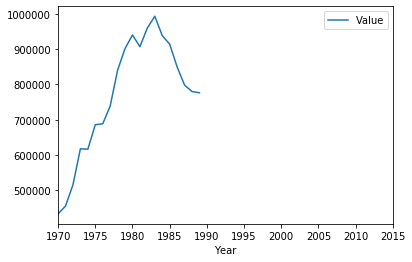

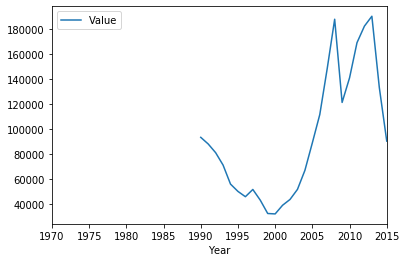

In [20]:
df_useful["GDP"][df_useful["GDP"]['Area']=='USSR'].plot(x ='Year', y='Value', kind = 'line')
df_useful["GDP"][df_useful["GDP"]['Area']=='Ukraine'].plot(x ='Year', y='Value', kind = 'line')

##### 1.D.b.ii. Proposed correction  <a name="1Dbii"></a> 

TODO (for countries which has appeared, give them value for previous year)
(for example in 1990 : Ukraine is X% of GPD of all countries that appeared from USSR so for 1970->1989 we give Ukraine value X%*GDP(USSR))

#### 1.D.c. Correcting inconsistent data entries  <a name="1Dc"></a>

In this section, we will create dataframes in `df_cleansed` which correspond to previous dataframes where the inconsistent data entries have been corrected.

In [21]:
df_cleansed = {}

### 1.E. Preprocessing the data set  <a name="1E"></a>

In this part, we will finish prepocessing the datasets. More precisely, we will deal with country names and normalizing the features.

#### 1.E.a. Converting country names between different naming conventions  <a name="1Ea"></a>

TODO, explain why (folium) + either Martin or Julien way to do it + show one map

In [22]:
def get_country_id(string_or,countries):
    
    countries.Name=countries.Name.apply(lambda x:x.lower())
    string=string_or.lower()
    
    if string in countries.Name:
        temp=countries.loc[countries.Name==string,'ID'].tolist
        return temp
    
    strs=string.split('-')
    if len(strs)>1:
        string= ' '.join(strs)

    if string=="côte d'ivoire":
        return ['CIV']
    if string=="united states of america":
        return ['USA']
    if string=="vietnam" or string=="viet nam":
        return ["VNM"]
    if string=="south africa":
        return ['ZAF']
    if string=='north korea' or string=="democratic people's republic of korea":
        return["PRK"]
    if string=="russian federation":
        return ["RUS"]
    if string=="cyprus":
        return ["CYP"]
    if string=="ussr":
        return ['RUS']
    delimiters = " and "," ",","
    pattern = '|'.join(map(re.escape, delimiters))
    strings=list(filter(None,re.split(pattern,string)))
    for s in strings:
        if s=="french":
            return ["FRA"]
        if s=="lao":
            return ["LAO"]
        if s in ['southern','islands','south','democratic','the','arab','united','central','states','republic','of','new','africa','america']:
            continue
        for name in countries.Name:
            if s in name.split():
                temp=countries.loc[countries.Name==name,'ID'].tolist()
                return temp
    return [np.nan]

def split_names(x):
    x=x.lower()
    if x!="guinea-bissau" and len(x.split('-'))>1:
        return x.split("-")
    if len(x.split(' & '))>1:
        return x.split(' & ')
    return x

def get_df_with_ids(df):
    
    df=df.copy()
    world_countries_file="Data/world-countries.json"
    geo_json_data=json.load(open(world_countries_file))
    names=[c['properties']['name'] for c in geo_json_data['features']]
    ids=[c['id'] for c in geo_json_data['features']]
    country_df=pd.DataFrame()
    country_df['Name']=names
    country_df['ID']=ids
    
    print("Exploding dataframe :")
    df.Area=df.Area.apply(lambda x: split_names(x))
    df=df.explode('Area')
    df.Area=df.Area.apply(lambda x:x.lower())
    
    print("Getting IDs :")
    
    countries_df=pd.DataFrame(df.Area.unique()).rename(columns={0:'Area'})
    
    countries_df['ID']=countries_df.Area.apply(lambda x: get_country_id(x,country_df)[0])
    countries_df.ID=countries_df.ID.replace("-99",np.nan)
    print(len(countries_df[countries_df.ID.isna()])," Countries without IDs")
    df=df.merge(countries_df,how='left')
    
    return df

In [28]:

def visualise_world_data_folium(df,year):
    world_countries_file="/Data/world-countries.json"
    geo_json_data=json.load(open(world_countries_file))
    to_plot=df[df.Year==year]
    to_plot=(to_plot[['ID','Value']]
             .groupby('ID')
             .sum()
             .reset_index()
             .dropna())
    to_plot.Value=np.log10(to_plot.Value)
    to_plot=to_plot.sort_values('Value',ascending=False)
    m=folium.Map(titles="test",location=[40,-10],zoom_start=1.6)
    plot1=folium.Choropleth(geo_data=geo_json_data,data=to_plot,
            columns=['ID','Value'],
            key_on='feature.id',
            fill_color='GnBu',fill_opacity=0.7,line_opacity=0.2,nan_fill_opacity=0.0)
    plot1.add_to(m)
    return m
    


def visualise_world_data_bokeh(df):
    #return a map plot of the data in df using bokeh and geopandas
    
    
    #import geodata
    geo_file = '/Data/geoData/ne_110m_admin_0_countries.shp'
    gdf = gpd.read_file(geo_file)[['ADMIN', 'ADM0_A3', 'geometry']]
    gdf.columns = ['Country', 'ID', 'geometry']
    
    #merging df
    merged=gpd.GeoDataFrame(gdf.merge(df,left_on='ID',right_on='ID',how='right'))
    
    #exporting to JSON
    merged=merged.sort_values('Value',ascending=False)
    json_data = merged.to_json()
    
    #plotting
    geosource = GeoJSONDataSource(geojson = json_data)

    #defining the color palette
    palette = brewer['YlGnBu'][7]
    palette = palette[::-1]

    #creating a color mapper assigning color to values
    minima=int(merged.Value.to_list()[-1])-1
    maxima=int(merged.Value.to_list()[0])+1
    step=int((maxima-minima)/8)
    color_mapper = LogColorMapper(palette="Viridis256", low=minima, high=maxima)

    #creating label for color bar legend
    tick_labels = {minima: str(minima), minima+step: str(minima+step), minima+2*step:str(minima+2*step), minima+3*step:str(minima+3*step), minima+4*step:str(minima+4*step),
                   minima+5*step:str(minima+5*step), minima+6*step:str(minima+6*step),minima+7*step:str(minima+7*step), maxima: str(maxima)}

    #Creating color bar. 
    color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None,location=(0,0))

    #creating the figure
    p = figure(title = 'Food crop production (log)', plot_height = 600 , plot_width = 950, toolbar_location = 'left')
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.visible=False

    #adding patches=heatmap overlay to the figure 
    p.patches('xs','ys', source = geosource, fill_color = {'field' :'Value', 'transform' : color_mapper},
              line_color = 'black', line_width = 0.2, fill_alpha = 1)

    #Specify figure layout.
    p.add_layout(color_bar, 'right')
    
    output_notebook()
    return p


#### 1.E.b. Normalization and log scales  <a name="1Eb"></a>

TODO, explain why (heavy tail, right skewed, power laws) + do it

For instance the distribution of GDP look a bit like a power law.

C:\Users\Martin\.conda\envs\ada\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Martin\.conda\envs\ada\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


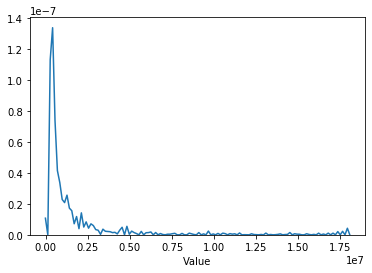

In [23]:
# NEED TO USE df_cleansed INSTEAD OF df_useful
sns.distplot(df_useful["GDP"]["Value"], rug=False, hist=False)

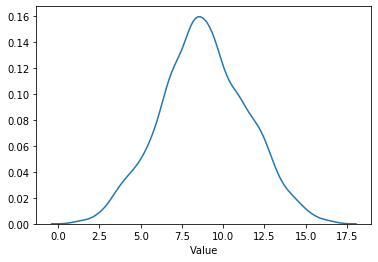

In [24]:
#looks better with log scale
sns.distplot(np.log(df_useful["GDP"]["Value"]), rug=False, hist=False)

### 1.F. Making one uniformized dataframe  <a name="1F"></a>

In this part, we will make one uniformized dataframe `uni_df` with the following columns.

(TO BE CHANGED, WAY MORE COLUMNS)

    Country | Year | GDP | Apples production | Livestock production | Crops importation | Livestock importation | Crops exportation | Livestock exportation
    
In this uniformized dataframe, a tuple `(Country, Year)` uniquely identifies a row.


#### 1.F.a. Pivoting dataframes with items  <a name="1Fa"></a>

In [25]:
# NEED TO USE df_cleansed INSTEAD OF df_useful
food_crop_area_df_pivoted = pd.pivot_table(df_useful['Crops Area harvested'], index=["Area Code","Area",'Year'], columns="Item", values="Value")
display(food_crop_area_df_pivoted.sample(10))

,,Item,"Anise, badian, fennel, coriander",Apples,Apricots,Areca nuts,Artichokes,Asparagus,Avocados,Bambara beans,Bananas,Barley,...,Sweet potatoes,"Tangerines, mandarins, clementines, satsumas",Taro (cocoyam),Tomatoes,Tung nuts,"Vegetables&Melons, Total",Vetches,Watermelons,Wheat,Yams
Area Code,Area,Year,,,,,,,,,,,,,,,,,,,,,
215,United Republic of Tanzania,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32500.0,100.0,...,32000.0,NaN,NaN,1700.0,NaN,124250.0,NaN,NaN,18000.0,700.0
256,Luxembourg,2014,NaN,242.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8317.0,...,NaN,NaN,NaN,1.0,NaN,49.0,NaN,NaN,12665.0,NaN
169,Paraguay,1978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9500.0,NaN,...,14606.0,NaN,NaN,3000.0,NaN,35258.0,NaN,12500.0,31500.0,NaN
4,Algeria,1976,NaN,3200.0,6000.0,NaN,4730.0,NaN,NaN,NaN,NaN,932350.0,...,NaN,15000.0,NaN,20310.0,NaN,114130.0,1980.0,23140.0,2295100.0,NaN
8,Antigua and Barbuda,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,NaN,...,41.0,NaN,11.0,47.0,NaN,521.0,NaN,NaN,NaN,39.0
4,Algeria,1964,NaN,2700.0,4200.0,NaN,4520.0,NaN,NaN,NaN,NaN,562040.0,...,NaN,17500.0,NaN,8260.0,NaN,52340.0,1180.0,18120.0,2186360.0,NaN
212,Syrian Arab Republic,1980,4700.0,23862.0,12732.0,NaN,NaN,NaN,NaN,NaN,2.0,1210192.0,...,NaN,NaN,NaN,34626.0,NaN,265358.0,63176.0,100410.0,1449056.0,NaN
72,Djibouti,1965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,280.0,NaN,NaN,NaN,NaN
157,Nicaragua,1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2450.0,NaN,...,NaN,NaN,1955.0,600.0,NaN,10750.0,NaN,NaN,NaN,76.0


In [26]:
# Deal with the NaN that appeared

#### 1.F.b. Merging everything  <a name="1Fb"></a>

In [27]:
def rename_columns(x, word):
    if x not in ['Area Code', 'Area', 'Year']:
        return x + ' ' + word
    return x
    
# NEED TO USE df_cleansed INSTEAD OF df_useful
gdp_df = df_useful['GDP'].rename(columns = {'Value':'GDP'})
food_area_df = food_crop_area_df_pivoted.rename(columns=lambda x: rename_columns(x, 'harvested area'))

pd.merge(gdp_df, food_area_df, how='outer', on=['Area', 'Area Code', 'Year'])

,Area Code,Area,Year,GDP,"Anise, badian, fennel, coriander harvested area",Apples harvested area,Apricots harvested area,Areca nuts harvested area,Artichokes harvested area,Asparagus harvested area,...,Sweet potatoes harvested area,"Tangerines, mandarins, clementines, satsumas harvested area",Taro (cocoyam) harvested area,Tomatoes harvested area,Tung nuts harvested area,"Vegetables&Melons, Total harvested area",Vetches harvested area,Watermelons harvested area,Wheat harvested area,Yams harvested area
0,2,Afghanistan,1970,1748.886597,NaN,3060.0,6630.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76400.0,NaN,10900.0,2176000.0,NaN
1,2,Afghanistan,1971,1831.108982,NaN,3060.0,6630.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76000.0,NaN,10900.0,2350000.0,NaN
2,2,Afghanistan,1972,1595.555482,NaN,3150.0,6810.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76800.0,NaN,10900.0,2897100.0,NaN
3,2,Afghanistan,1973,1733.333275,NaN,3210.0,6950.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76000.0,NaN,10900.0,2300000.0,NaN
4,2,Afghanistan,1974,2155.555500,NaN,3270.0,7070.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,78100.0,NaN,11200.0,2277600.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12466,351,China,2010,NaN,37000.0,2140171.0,21709.0,45832.0,10000.0,1280576.0,...,3554271.0,1409494.0,92693.0,951735.0,155000.0,23622198.0,NaN,1824104.0,24257900.0,NaN
12467,351,China,2011,NaN,37503.0,2177495.0,21053.0,45952.0,11000.0,1320585.0,...,3490913.0,1509323.0,92370.0,959737.0,158000.0,24222990.0,NaN,1814893.0,24272245.0,NaN
12468,351,China,2012,NaN,37000.0,2231519.0,20667.0,45521.0,12000.0,1350614.0,...,3363505.0,1519084.0,94345.0,954012.0,154000.0,24255558.0,NaN,1813401.0,24141051.0,NaN
12469,351,China,2013,NaN,37500.0,2272375.0,20934.0,45329.0,12000.0,1330608.0,...,3358323.0,1595299.0,95312.0,985712.0,154000.0,24360415.0,NaN,1838948.0,24119335.0,NaN


### 2. Data exploration and first observations  <a name="2"></a>

2. 
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Prices of food](#2B)      
                
    3. [Structure of international trade](#2C)       
        
    4. [Economic classification of countries](#2D)  
        
In this part, we will explore the dataset with more details. We will first see in more detail the [food productions, importations and exportations](#2A), next examine the [Prices of food](#2B), then study the [structure of international trade](#2C) and finally look at the [economic classification of countries](#2D).

#### 2.A. Food productions, importations and exportations <a name="2A"></a>

2. 
        
    1. 
    
        1. [Crops and livestock production and trade](#2Aa)  
    
            1. [Crops](#2Aai)
            
                1. [Production](#2Aai1)
                
                2. [Importation](#2Aai2)
                
                3. [Exportation](#2Aai3)
    
            2. [Livestock](#2Aaii)  
            
                1. [Production](#2Aaii1)
                
                2. [Importation](#2Aaii2)
                
                3. [Exportation](#2Aaii3)
    
            2. [Globally](#2Aaiii)             
    
        2. [Introducing the concept of food self-sufficiency](#2Ab)
    
            1. [Basic idea](#2Abi)
    
            2. [Formula and computation](#2Abii)
            
TODO

#### 2.B. Prices of food  <a name="2B"></a>

2. 
        
    2. 
    
        1. [Prices](#2Ba) 
    
        2. [Stability of prices](#2Bb)      
        
TODO

#### 2.C. Structure of international trade  <a name="2C"></a>

2.  
                
    3. 
    
        1. [One word about historical context](#2Ca) 
    
        2. [Clusters, circularity and openness rates of international trade](#2Cb)   

TODO

#### 2.D. Economic classification of countries <a name="2D"></a>
TODO

### 3. Descriptive data analysis  <a name="3"></a>

3. 

    1. [Production and consumption of food from a time-space geography point of view](#3A)
        
        1. [Net food exporters or importers](#3Aa)
        
        2. [Evolution over the last few decades](#3Ab)

    1. [Food self-sufficiency](#3B)

    2. [Giving countries an economic score based on their agricultural features](#3C)
        
        1. [Correlation between food trade feature and GDP](#3Ca)
        
        2. [Our own score](#3Cb)
        
        2. [Machine learning model](#3Cc)  

    3. [Food prices stability and agricultural features](#3C)  
    
TODO

### 4. Informed plan for next actions  <a name="4"></a>

TODO